In [6]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [5]:
#setting cho tensorflow chạy bằng gpu
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load dataset

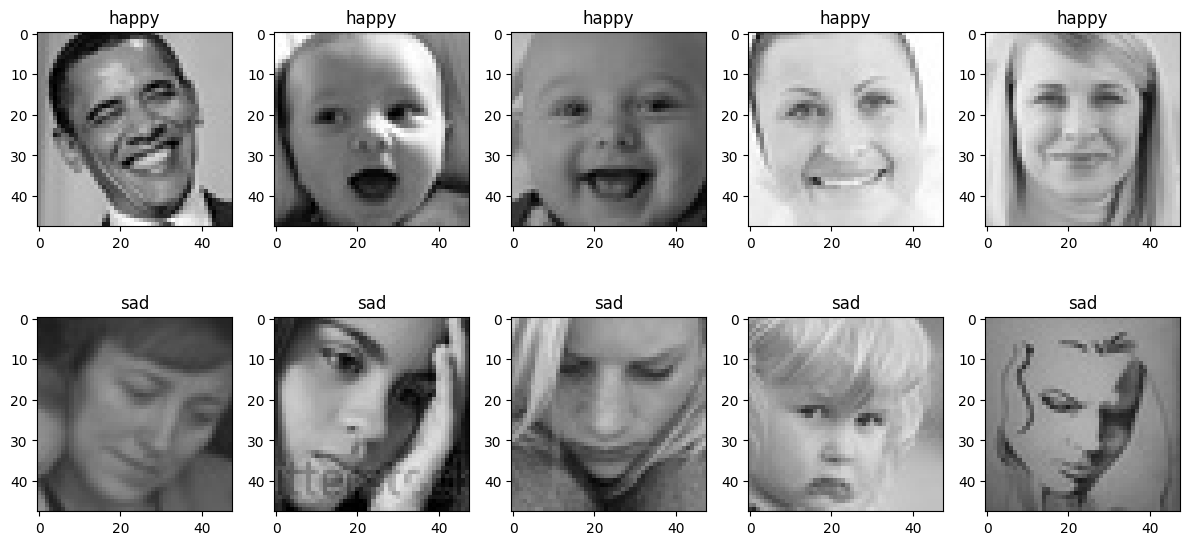

In [6]:
# Dữ liệu gồm tập các ảnh mặt buồn và vui
# Kích thước ảnh: 48*48 pixels
pic_size = 48

# file chứa dataset
base_path = "./data/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")
        plt.title(expression)

plt.tight_layout()
plt.show()

Tiền xử lý

In [8]:
# xây dựng dữ liệu để training
batch_size = 128
base_path = "./data/"

train_datagen  = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True,
                                   preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
validation_datagen = ImageDataGenerator(rescale= 1.0/255, preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(base_path+"train",
                                              target_size = (56,56),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


validation_generator = validation_datagen.flow_from_directory(base_path+"validation",
                                              target_size = (56,56),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 12103 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


Xây dựng Model

In [10]:
# số nhãn
from tensorflow.keras.applications.resnet import ResNet50
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
nb_classes = 2
model = Sequential()
model.add(ResNet50(input_shape=(56, 56, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(nb_classes,activation='softmax'))
print(model.summary())
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:

# Khối Residual
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, (3, 3), padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')
        self.conv2 = Conv2D(filters, (3, 3), padding='same')
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        identity = inputs
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += identity
        x = self.relu(x)
        return x

# Mạng CNN với khối ResNet
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(56, 56, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Residual block 1
model.add(ResidualBlock(128))

# 3rd Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Residual block 2
model.add(ResidualBlock(512))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(nb_classes, activation='softmax'))

Training

In [34]:
# Số lần chạy
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("model_weights_resnet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=epochs,
        validation_data = validation_generator,
        validation_steps = validation_generator.n//validation_generator.batch_size,
        callbacks=callbacks_list)

Epoch 1/50
94/94 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9468
Epoch 1: val_accuracy improved from -inf to 0.90761, saving model to model_weights_resnet.h5
94/94 [==============================] - 29s 303ms/step - loss: 0.1344 - accuracy: 0.9468 - val_loss: 0.2630 - val_accuracy: 0.9076
Epoch 2/50
94/94 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9466
Epoch 2: val_accuracy improved from 0.90761 to 0.90897, saving model to model_weights_resnet.h5
94/94 [==============================] - 31s 328ms/step - loss: 0.1328 - accuracy: 0.9466 - val_loss: 0.2470 - val_accuracy: 0.9090
Epoch 3/50
94/94 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9506
Epoch 3: val_accuracy improved from 0.90897 to 0.91440, saving model to model_weights_resnet.h5
94/94 [==============================] - 31s 327ms/step - loss: 0.1256 - accuracy: 0.9506 - val_loss: 0.2604 - val_accuracy: 0.9144
Epoch 4/50
94/94 [===================

Đồ thị

In [35]:
# tạo đồ thị
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# in ra lần thử tốt nhất

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

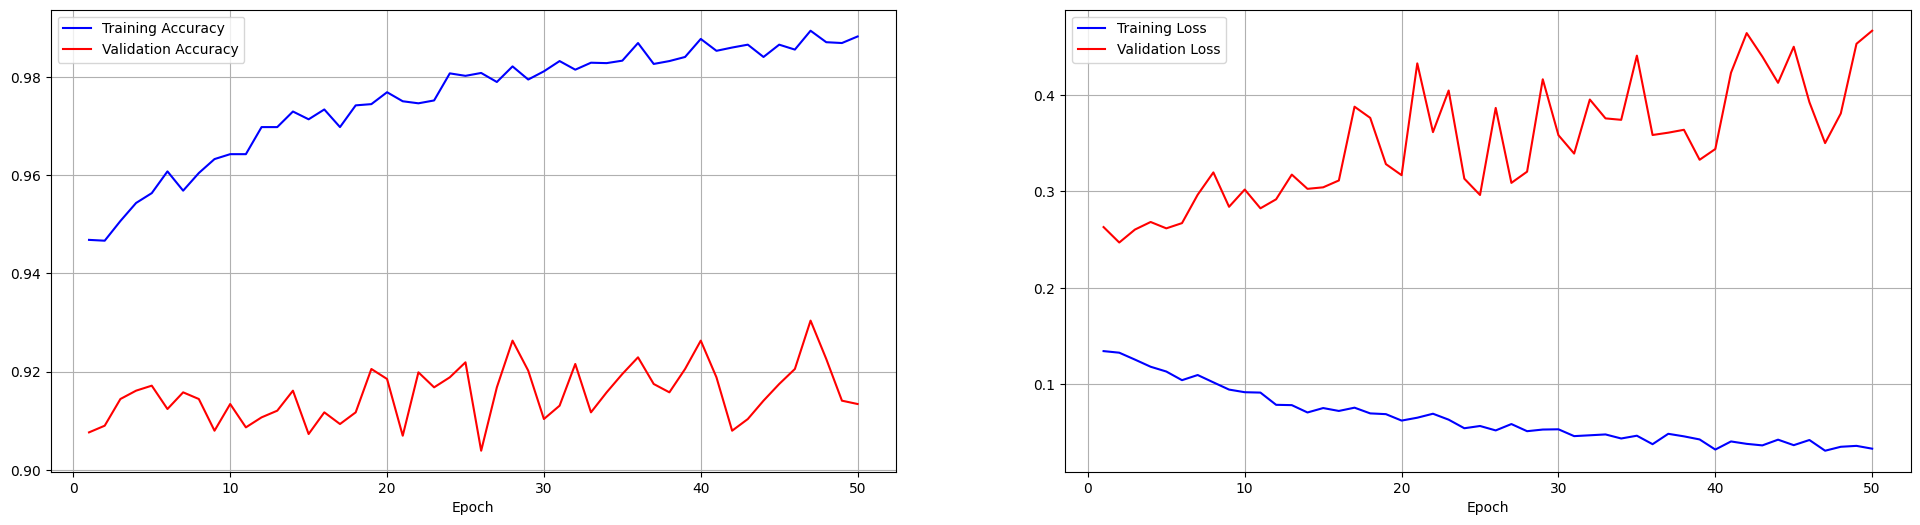

Best Validation Accuracy Score 0.93037, is for epoch 47


In [36]:
plot_results(history)
best_epoch =get_best_epcoh(history)

TESTING

In [5]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
loaded_model = load_model('model_weights_resnet.h5')

(56, 56, 3)


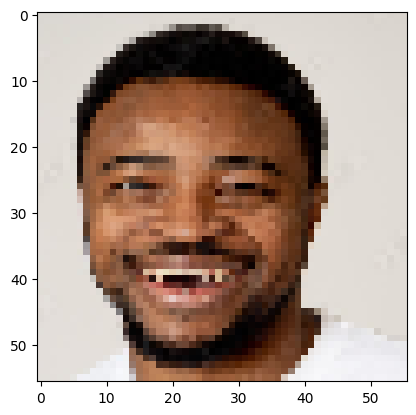

In [6]:
image = cv2.imread('./test/happy1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (56, 56))
print(image.shape)
plt.imshow(image)

In [7]:
result = np.argmax(loaded_model.predict(np.expand_dims(image/255, 0)))
result

1/1 [==============================] - 3s 3s/step


0

In [8]:
if result == 0:
    print("happy")
if result == 1:
    print("sad")

happy
